# InVivo Technical Test
Use RDkit to read in SMILES. 
Scikit-learn and Pytorch for analysis. 

conda install -c statiskit libboost_python

conda install -c rdkit rdkit

conda install -c conda-forge matplotlib

conda install pandas


In [23]:
import numpy as np
from pprint import pprint
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##  Preliminary Data Analysis

In [10]:
### load the molecule names and check if RDKit can read them all
with open("data.csv") as f:
    moleculeSMILES = [row.split(',')[0] for row in f]
moleculeSMILES = moleculeSMILES[1:]
targetLabels = np.genfromtxt("data.csv",
                             skip_header=1,
                             usecols=np.arange(1,13),
                             delimiter=",",
                             filling_values="-1",
                             dtype=np.int8,
                             comments="~") # change the comment symbol since pound is part of SMILES


In [11]:
molecules = [Chem.MolFromSmiles(m) for m in moleculeSMILES]
pprint(sum(x is None for x in molecules)) ## counts the number of molecules not loaded properly
moleculeFPS = [GetMorganFingerprint(x,3) for x in molecules]

0


In [50]:
# from https://www.rdkit.org/docs/GettingStartedInPython.html
def distij(i,j,fps=moleculeFPS):
    return 1-DataStructs.DiceSimilarity(fps[int(i)],fps[int(j)])

def distTanimoto(i,j,fps=moleculeFPS):
    return 1-DataStructs.TanimotoSimilarity(fps[int(i)],fps[int(j)])

## Select subset for target 1 to get to know data a bit more

In [51]:
target1PositiveIndexSubset = np.argwhere(targetLabels[:,1]==1).flatten()
target1NegativeIndexSubset = np.argwhere(targetLabels[:,1]==0).flatten()[0:400]
totalCount = target1PositiveIndexSubset.size + target1NegativeIndexSubset.size
positiveCount = target1PositiveIndexSubset.size
X = np.zeros((totalCount,1))
X[0:positiveCount,0] = target1PositiveIndexSubset
X[positiveCount:totalCount,0] = target1NegativeIndexSubset
y = np.zeros(totalCount)
y[0:positiveCount] += 1
pprint("{1}/{0}".format(totalCount, positiveCount))

'238/638'


Test TSNE using the  with a subset of Target 1 data for visualization 

In [52]:
X_embedded = TSNE(n_components=2, metric=distTanimoto).fit_transform(X)
X_embedded.shape

(638, 2)

Text(0.5, 1.0, 'TSN target 1 subset')

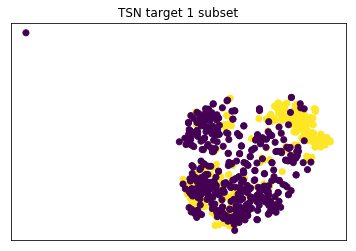

In [53]:
fig = plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)
plt.xticks([]), plt.yticks([])
plt.title('TSN target 1 subset')

In [49]:
moleculeFPS[0]